# Whisper or scream?

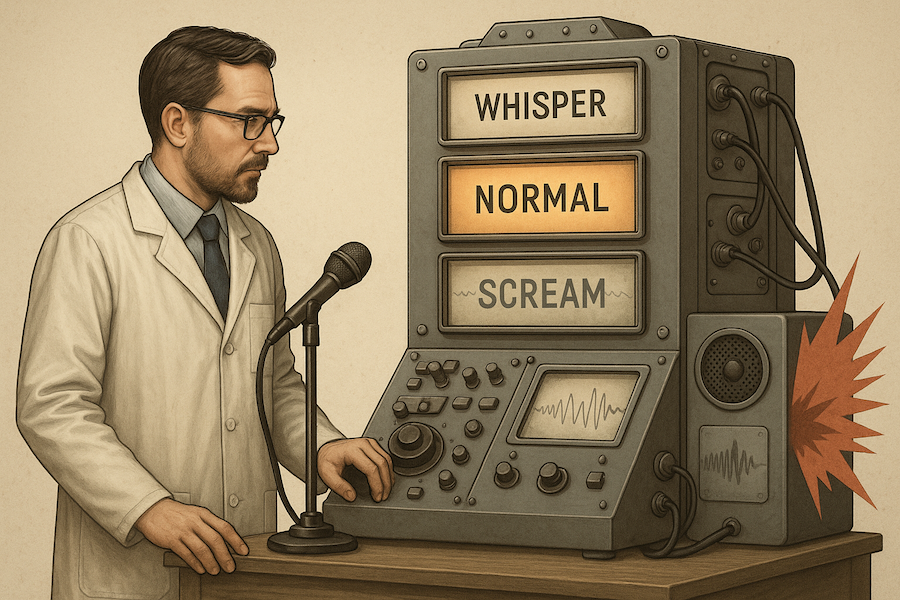


*Image generated by the ChatGPT image generation tool.*

## Introduction

There is a unique excitement at the Institute of Advanced Experimental Acoustics. After many years, the prototype of the **Speech Loudness Assessment Machine** has been launched, an advanced device that can assess the loudness of speech.

Or at least it **should** be able to.

Unfortunately, the machine is missing one key functionality - a good model that can recognize whether a word was spoken **normally, whispered, or shouted**. Without it, the device's lights flash in a completely random manner, which, according to the research team, somewhat lowers user confidence.

Your task is to prepare a model that will allow this machine to operate as specified in the documentation.

## Task

Implement a model that classifies audio recordings into three classes:

- `0` (`normal`) - a word spoken in a normal tone,

- `1` (`scream`) - a word spoken as a shout,

- `2` (`whisper`) - a word spoken as a whisper.

## Data

In this task, two datasets are available to you:

- **training** - $2,400$ samples,

- **validation** - $200$ samples.

The hidden test set, on which your solution will be evaluated, has $400$ samples.

All recordings have a sampling frequency of 16 kHz and contain single words in Polish, the meaning of which does not affect the task.

## Evaluation Criterion

Your solution will be evaluated based on **balanced accuracy**:

$$ \text{BalancedAccuracy} = \frac{1}{3} \sum_{k} \frac{\text{TP}_k}{\text{TP}_k + \text{FN}_k} $$

where $k \in \{0, 1, 2\}$, $\text{TP}$ - the number of samples for which the model correctly detected a given class, and $\text{FN}$ - the number of samples for which the model did not detect a given class.

For this task, you can score between 0 and 100 points. The score will be scaled linearly depending on the Balanced Accuracy value:

- **Balanced Accuracy $\leq$ 0.6**: 0 points.

- **Balanced Accuracy $\geq$ 0.99**: 100 points.

- **Values between 0.6 and 0.99**: scaled linearly.

Formula for the score:

$$ \text{Points} = \begin{cases} 
0 & \text{for } \text{Balanced Accuracy} \leq 0.6 \\
100 \times \frac{\text{Balanced Accuracy} - 0.6}{0.99 - 0.6} & \text{for } 0.6 < \text{Balanced Accuracy} < 0.99 \\
100 & \text{for } \text{Balanced Accuracy} \geq 0.99
\end{cases} $$

## Constraints

- You can use a GPU in this task.

- The evaluation of your final solution on the Competition Platform cannot take longer than 5 minutes with a GPU.

- List of allowed libraries: `sklearn`, `tqdm`, `seaborn`, `matplotlib`, `numpy`, `torch`, `torchaudio`, `librosa`.

- The model must inherit from the `nn.Module` class.

## Notes and Tips

- The recordings are normalized to the same volume level.

- You can validate your solution on the training and validation sets, but the score for the task will be awarded only based on the result on the test set.

## Submission Files

This notebook completed with your solution (see the `YourClassifier` class).

## Evaluation

Remember that during the check, the `FINAL_EVALUATION_MODE` flag will be set to True.

For this task, you can score between 0 and 100 points. The number of points you will get will be calculated on the (secret) test set on the Competition Platform based on the aforementioned formula, rounded to the nearest integer. If your solution does not meet the above criteria or does not execute correctly, you will receive 0 points for the task.

## Starter Code

In this section, we initialize the environment by importing the necessary libraries and functions. The prepared code will make it easier for you to operate on data efficiently and build the proper solution.

In [ ]:
######################### DO NOT CHANGE THIS CELL ##########################

FINAL_EVALUATION_MODE = False  # We will set this flag to True during evaluation.

In [ ]:
######################### DO NOT CHANGE THIS CELL ##########################

import os
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import torchaudio
import librosa
from typing import Callable
from torch.utils.data import Dataset
from tqdm import tqdm
from torch.utils.data import DataLoader
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from IPython.display import Audio

if not FINAL_EVALUATION_MODE:
    import gdown

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

assert torch.cuda.is_available(), "CUDA unavailable!"

In [ ]:
######################### DO NOT CHANGE THIS CELL ##########################

seed = 12345

os.environ["PYTHONHASHSEED"] = str(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
######################### DO NOT CHANGE THIS CELL ##########################
# A cell containing auxiliary functions for data preparation.

class WhisperScreamDataset(Dataset):
    """
    A data set loaded from an npz file.

    Args:
        path (str): Path to the npz file containing the data.
    """
    def __init__(self, path: str) -> None:
        data = np.load(path, allow_pickle=True)

        self.signals = data["signals"]
        self.labels = data.get("labels", None)
        self.sr = int(data["sr"])

        if self.labels is None:
            self.labels = [-1] * len(self.signals)

    def __len__(self) -> int:
        """Returns the number of samples in the dataset."""
        return len(self.signals)

    def __getitem__(self, index: int) -> dict:
        sig = self.signals[index]
        label = self.labels[index]
        sig = torch.tensor(sig, dtype=torch.float32)
        return {"audio": sig, "label": label}


def setup_data(root: str = "data/") -> tuple:
    """
    Prepares datasets for training and validation, downloading them as needed.
    
    Args:
        root (str, optional): Base directory for data files.
    
    Returns:
        tuple: Datasets (train_ds, val_ds).
    """
    train_file = root + "train.npz"
    val_file = root + "val.npz"

    if not os.path.exists(root):
        os.makedirs(root)
    
    if not os.path.exists(train_file):
        url = "https://drive.google.com/uc?id=1WpPqcKTh_jzCsBm7k32IRtqlsxgpV8u4"
        gdown.download(url, train_file, quiet=True)
    
    if not os.path.exists(val_file):
        url = "https://drive.google.com/uc?id=1PwVhwFAGX3cS9gA7SYbJORjpQroPVQEN"
        gdown.download(url, val_file, quiet=True)
    
    train_ds = WhisperScreamDataset(train_file)
    val_ds = WhisperScreamDataset(val_file)

    return train_ds, val_ds

In [ ]:
######################### DO NOT CHANGE THIS CELL ##########################
# A cell containing auxiliary functions for determining metrics assessing the quality of the model.

def predict(model_predict: Callable, dataset: Dataset) -> list:
    """
    A function that predicts all labels for a dataset using a prediction function.

    Args:
        model_predict (Callable): A prediction function that returns a list of labels.
        dataset (Dataset): A dataset.

    Returns:
        list: A list containing all predicted labels for each sample in the dataset.
    """
    predicted = []
    
    for sample in dataset:
        x = sample["audio"].to(DEVICE)
        pred = model_predict(x)
        predicted.append(pred)

    return predicted


def calculate_balanced_accuracy(predicted: list, dataset: Dataset) -> float:
    """
    A function that calculates balanced accuracy for predicted labels for the entire dataset.

    Args:
        predicted (list): A list containing predicted labels for each sample in the dataset.
        dataset (Dataset): A dataset containing the expected labels.
    """
    expected = [sample["label"] for sample in dataset]
    return balanced_accuracy_score(y_true=expected, y_pred=predicted)


def plot_confusion_matrix(predicted: list, dataset: Dataset) -> None:
    """
    A function that displays the confusion matrix for recording classification.

    Args:
        predicted (list): A list of predicted labels.
        dataset (Dataset): A set of data.
    """
    expected = [sample["label"] for sample in dataset]
    conf_matrix = confusion_matrix(expected, predicted)

    labels = ["normal", "scream", "whisper"]
    plt.figure(figsize=(6, 4))
    sns.heatmap(
        conf_matrix, 
        annot=True, 
        fmt="d", 
        cmap="Blues", 
        xticklabels=labels, 
        yticklabels=labels,
        cbar=False,
    )

    plt.xlabel("Labels provided", labelpad=15)
    plt.ylabel("Expected labels", labelpad=15)
    plt.xticks(rotation=45)

    plt.title("Confusion matrix for recording classification")
    plt.show()


def evaluate_algorithm(your_model_predict: Callable, dataset: Dataset):
    """
    A function used to evaluate the solution.

    Args:
        your_model_predict (Callable): A prediction function that returns a list of labels.
        dataset (Dataset): The dataset on which the solution will be evaluated.
    """
    your_out = predict(your_model_predict, dataset)
    
    your_balanced_accuracy = calculate_balanced_accuracy(your_out, dataset)
    score = (np.clip(your_balanced_accuracy, 0.6, 0.99) - 0.6) / (0.99 - 0.6) * 100
    score = int(round(score))

    print(f"Balanced accuracy on the validation set: {your_balanced_accuracy:.4f}")
    print(f"Estimated number of points for the task: {score}")

    plot_confusion_matrix(your_out, dataset)

## Loading data

Using the code below, the data will be loaded and prepared accordingly.

In [ ]:
######################### DO NOT CHANGE THIS CELL ##########################

if not FINAL_EVALUATION_MODE:
    train_ds, val_ds = setup_data(root="data/")

    print(f"Number of recordings in the training set: {len(train_ds)}")
    print(f"Number of recordings in the validation set: {len(val_ds)}")
    print(f"Each sample contains: {list(train_ds[0].keys())}")

Aby odsłuchać przykładową próbkę, możesz skorzystać z poniższego kodu.

In [ ]:
######################### DO NOT CHANGE THIS CELL ##########################

if not FINAL_EVALUATION_MODE:
    sample = next(iter(train_ds))
    waveform = sample["audio"].cpu().numpy()

    if waveform.ndim == 2:
        waveform = waveform.T

    Audio(waveform, rate=16000)

## Example Solution

Below we present a simplified solution that demonstrates the basic functionality
of the notebook. It can serve as a starting point for developing your own solution.

In [ ]:
######################### DO NOT CHANGE THIS CELL ##########################

class DummyClassifier(nn.Module):
    def __init__(self, in_features: int):
        super(DummyClassifier, self).__init__()
        self.max_len = in_features
        self.linear = nn.Linear(in_features=in_features, out_features=3)
    
    def forward(self, audio: torch.Tensor) -> torch.Tensor:
        """
        A function that classifies recording x into one of three classes: 0 - normal, 1 - scream, 2 - whisper.

        Args:
            x (torch.Tensor): Recording to classify.
        
        Returns:
            torch.Tensor: Model predictions.
        """
        x = self.linear(audio)
        return nn.functional.softmax(x, dim=0)
    
    @torch.no_grad()
    def predict(self, audio: torch.Tensor) -> list[int]:
        """
        A function that predicts a label for recording `x`.

        Args:
            x (torch.Tensor): Recording to classify.
        
        Returns:
            list[int]: List of predicted labels.
        """
        if audio.size(-1) < self.max_len:
            audio = nn.functional.pad(audio, (0, self.max_len - audio.size(-1)))
        elif audio.size(-1) > self.max_len:
            audio = audio[:self.max_len]
        if audio.dim() < 2:
            audio = audio.view(1, -1)
        self.eval()
        logits = self.forward(audio)
        preds_idx = torch.argmax(logits, dim=1)
        return preds_idx.tolist()

In [ ]:
######################### DO NOT CHANGE THIS CELL ##########################

class DataPreprocessor:
    def __init__(self, max_len: int) -> None:
        self.max_len = max_len
    
    def __call__(self, batch: list) -> dict:
        audios, labels = [], []

        for sample in batch:
            audio = sample["audio"]

            if audio.size(-1) < self.max_len:
                audio = nn.functional.pad(audio, (0, self.max_len - audio.size(-1)))
            elif audio.size(-1) > self.max_len:
                audio = audio[:self.max_len]
            
            label = sample["label"]

            audios.append(audio)
            labels.append(label)
        
        return {"audios": torch.stack(audios, dim=0), "labels": torch.tensor(labels)}

In [ ]:
######################### DO NOT CHANGE THIS CELL ##########################

def train_eval_dummy_classifier(train_ds: Dataset, val_ds: Dataset):
    max_len = 0

    for sample in train_ds:
        audio = sample["audio"]
        if audio.size(-1) > max_len:
            max_len = audio.size(-1)

    print(f"The longest recording in the training set has a length of: {max_len}") # It should be 80000.

    preprocess = DataPreprocessor(max_len=max_len)

    model = DummyClassifier(in_features=max_len).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    train_dl = DataLoader(train_ds, batch_size=2, shuffle=True, collate_fn=preprocess)

    epochs = 1

    pbar = tqdm(range(epochs), desc="Training", total=epochs)
    for _ in pbar:
        epoch_losses = []

        for batch in train_dl:
            x = batch["audios"].to(DEVICE)
            y = batch["labels"].to(DEVICE)

            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.detach().cpu().item())

        avg_loss = np.mean(epoch_losses)
        pbar.set_postfix({"train loss": avg_loss})

    model.eval()

    evaluate_algorithm(model.predict, val_ds)

In [ ]:
######################### DO NOT CHANGE THIS CELL ##########################

if not FINAL_EVALUATION_MODE:
    train_eval_dummy_classifier(train_ds, val_ds)

## Your solution

Your solution should be placed in this section. Make changes only here!

Your model must be saved under the `your_model` variable. Additionally, it must have a `.predict()` method, which will return a list of predicted labels. It is the `your_model.predict` method that constitutes the final solution and will be evaluated.

In [ ]:
# Here you can implement your classifier which will return a list of predicted labels.

class YourClassifier(nn.Module):
    def __init__(self):
        # Here you can initialize your model
        super(YourClassifier, self).__init__()
        pass

    def forward(self, audio: torch.Tensor) -> torch.Tensor:
        # Implement your classifier logic here.
        pass
    
    def predict(self, audio: torch.Tensor) -> list:
        # Implement prediction here.
        # Example model that always returns the same label:
        return [0]

In [ ]:
train_ds, val_ds = setup_data(root="data/")

# Train your model here.
# ...

your_model = YourClassifier()

## Evaluation

The following code will be used for evaluating the solution. After sending the solution to us, the `evaluate_algorithm(your_model.predict, test_ds)` function will be executed, i.e., almost identical code as below will be run on a test set available only to the task graders.

Before submitting, make sure that the entire notebook executes from start to finish without errors and without user intervention after running the `Run All` command.

In [ ]:
######################### DO NOT CHANGE THIS CELL ##########################

if not FINAL_EVALUATION_MODE:
    evaluate_algorithm(your_model.predict, val_ds)